<a href="https://colab.research.google.com/github/descartesmbogning/topic-modeling-lda/blob/main/Patent_optimal_topics_numb_23102023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

import spacy
import codecs
import re
from wordcloud import STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
from nltk.stem.porter import PorterStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/patent-phage-therapy-lens-23102023-tiab.csv')
pd.set_option('display.max_columns', None)
print(len(df))
df.head()

2365


,#,Jurisdiction,Kind,Display Key,Lens ID,Publication Date,Publication Year,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status
0,1,RU,C2,RU 2214829 C2,069-390-611-717-343,2003-10-27,2003,RU 2001129920 A,2001-11-05,RU 2001129920 A,2001-11-05,METHOD FOR TUBERCULOSIS PHAGOTHERAPY,"FIELD: medicine, phthisiology. SUBSTANCE: meth...",NOVOSIB NII T;;UBERKULEZA,KURUNOV JU N;;KURUNOVA N N;;SHATALOVA N D,NaN,https://lens.org/069-390-611-717-343,Granted Patent,no,0,4,1,1,0,NaN,A61K35/76;;A61P31/06,NaN,0,0,NaN,NaN,NaN,EXPIRED
1,2,JP,A,JP 2016104011 A,114-759-028-882-736,2016-06-09,2016,JP 2015243657 A,2015-12-14,US 38401510 P,2010-09-17,"ANTIBACTERIAL PHAGES, PHAGE PEPTIDES AND USE M...",PROBLEM TO BE SOLVED: To provide novel bacteri...,TECNIFAR-INDUSTRIA TECNICA FARM S A;;TECHNOPHA...,MIGUEL ANGELO DA COSTA GARCIA;;CARLOS JORGE SO...,NaN,https://lens.org/114-759-028-882-736,Patent Application,no,1,1,48,48,1300,C12N2795/00032;;A61K31/505;;A61K31/7056;;A61K3...,C12N7/00;;A61K35/76;;A61P31/04;;C12N15/09,NaN,0,0,NaN,NaN,NaN,ACTIVE
2,3,AU,A1,AU 2015/255318 A1,094-982-928-461-863,2015-12-03,2015,AU 2015/255318 A,2015-11-13,AU 2015/255318 A;;AU 2010/211456 A;;US 2183450...,2009-02-06,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECNIFAR INDÚSTRIA TÉCNICA FARMACÉUTICA S A;;T...,DA COSTA GARCIA MIGUEL ÂNGELO;;SOUSA DE SÃO JO...,"TECHNOPHAGE, INVESTIGACAO E DESENVOLVIMENTO EM...",https://lens.org/094-982-928-461-863,Patent Application,no,0,0,3,45,0,NaN,A61K35/76;;C12N9/14;;G01N33/569,NaN,0,0,NaN,NaN,NaN,ACTIVE
3,4,US,A1,US 2016/0022747 A1,167-908-891-122-112,2016-01-28,2016,US 201514852112 A,2015-09-11,US 201514852112 A;;US 201113148009 A;;PT 20100...,2009-02-06,"Antibacterial Phage, Phage Peptides and Method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,https://lens.org/167-908-891-122-112,Patent Application,yes,0,1,42,45,816,A61K38/00;;A61K45/06;;C07K14/005;;C12N7/00;;C1...,A61K35/76;;A61K9/00;;C12N7/00,NaN,0,0,NaN,NaN,NaN,ACTIVE
4,5,AU,A1,AU 2017/204331 A1,112-018-476-081-94X,2017-07-13,2017,AU 2017/204331 A,2017-06-26,AU 2017/204331 A;;AU 2015/255313 A;;AU 2011/30...,2011-09-19,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,NaN,https://lens.org/112-018-476-081-94X,Patent Application,no,0,3,1,1,0,Y02A50/30,A61K35/76;;C12N7/00,NaN,0,0,NaN,NaN,NaN,DISCONTINUED


In [ ]:
data = df[(~pd.isnull(df['Abstract'])) & (~pd.isnull(df['Title']))]
len(data)

2348

# preprocessing data

In [ ]:
import nltk
nltk.download('wordnet')

import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download stopwords for all languages
nltk.download('stopwords')

def get_all_stopwords():
    """
    Function to get stopwords from all languages available in NLTK.
    """
    all_stopwords = set()
    for language in stopwords.fileids():
        all_stopwords.update(stopwords.words(language))
    return all_stopwords

all_stopwords = get_all_stopwords()

def clean_text(text):
    """
    Function to clean text data.
    - Lowercases the text
    - Removes special characters and numbers
    - Removes stopwords from all languages
    - Lemmatizes the text
    """
    # Lowercase text
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in all_stopwords])
    # Lemmatize text
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

def clean_data_func(data, columns_to_clean):
    """
    Cleans specified columns in a pandas DataFrame for TF-IDF using all stopwords and
    merges them into a new column.

    Args:
    data (DataFrame): Pandas DataFrame containing the data.
    columns_to_clean (list of str): List of column names in the DataFrame to clean.

    Returns:
    DataFrame: The DataFrame with an additional cleaned column.
    """
    # Check if the columns exist
    for col in columns_to_clean:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in DataFrame.")

    # Merge the columns to clean
    data['merged_for_cleaning'] = data[columns_to_clean].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

    # Clean the merged column
    data['cleaned_merged_column'] = data['merged_for_cleaning'].apply(clean_text)

    # Drop the temporary merged column
    data = data.drop(columns=['merged_for_cleaning'])

    return data


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Columns you want to clean
columns_to_clean = ['Title', 'Abstract']

# Call the function
cleaned_data = clean_data_func(data, columns_to_clean)

# Display the cleaned DataFrame
cleaned_data

<ipython-input-112-82cc4b940a61>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['merged_for_cleaning'] = data[columns_to_clean].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
<ipython-input-112-82cc4b940a61>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_merged_column'] = data['merged_for_cleaning'].apply(clean_text)


,#,Jurisdiction,Kind,Display Key,Lens ID,Publication Date,Publication Year,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status,cleaned_merged_column
0,1,RU,C2,RU 2214829 C2,069-390-611-717-343,2003-10-27,2003,RU 2001129920 A,2001-11-05,RU 2001129920 A,2001-11-05,METHOD FOR TUBERCULOSIS PHAGOTHERAPY,"FIELD: medicine, phthisiology. SUBSTANCE: meth...",NOVOSIB NII T;;UBERKULEZA,KURUNOV JU N;;KURUNOVA N N;;SHATALOVA N D,NaN,https://lens.org/069-390-611-717-343,Granted Patent,no,0,4,1,1,0,NaN,A61K35/76;;A61P31/06,NaN,0,0,NaN,NaN,NaN,EXPIRED,method tuberculosis phagotherapy field medicin...
1,2,JP,A,JP 2016104011 A,114-759-028-882-736,2016-06-09,2016,JP 2015243657 A,2015-12-14,US 38401510 P,2010-09-17,"ANTIBACTERIAL PHAGES, PHAGE PEPTIDES AND USE M...",PROBLEM TO BE SOLVED: To provide novel bacteri...,TECNIFAR-INDUSTRIA TECNICA FARM S A;;TECHNOPHA...,MIGUEL ANGELO DA COSTA GARCIA;;CARLOS JORGE SO...,NaN,https://lens.org/114-759-028-882-736,Patent Application,no,1,1,48,48,1300,C12N2795/00032;;A61K31/505;;A61K31/7056;;A61K3...,C12N7/00;;A61K35/76;;A61P31/04;;C12N15/09,NaN,0,0,NaN,NaN,NaN,ACTIVE,antibacterial phage phage peptide method there...
2,3,AU,A1,AU 2015/255318 A1,094-982-928-461-863,2015-12-03,2015,AU 2015/255318 A,2015-11-13,AU 2015/255318 A;;AU 2010/211456 A;;US 2183450...,2009-02-06,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECNIFAR INDÚSTRIA TÉCNICA FARMACÉUTICA S A;;T...,DA COSTA GARCIA MIGUEL ÂNGELO;;SOUSA DE SÃO JO...,"TECHNOPHAGE, INVESTIGACAO E DESENVOLVIMENTO EM...",https://lens.org/094-982-928-461-863,Patent Application,no,0,0,3,45,0,NaN,A61K35/76;;C12N9/14;;G01N33/569,NaN,0,0,NaN,NaN,NaN,ACTIVE,antibacterial phage phage peptide method there...
3,4,US,A1,US 2016/0022747 A1,167-908-891-122-112,2016-01-28,2016,US 201514852112 A,2015-09-11,US 201514852112 A;;US 201113148009 A;;PT 20100...,2009-02-06,"Antibacterial Phage, Phage Peptides and Method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,https://lens.org/167-908-891-122-112,Patent Application,yes,0,1,42,45,816,A61K38/00;;A61K45/06;;C07K14/005;;C12N7/00;;C1...,A61K35/76;;A61K9/00;;C12N7/00,NaN,0,0,NaN,NaN,NaN,ACTIVE,antibacterial phage phage peptide method there...
4,5,AU,A1,AU 2017/204331 A1,112-018-476-081-94X,2017-07-13,2017,AU 2017/204331 A,2017-06-26,AU 2017/204331 A;;AU 2015/255313 A;;AU 2011/30...,2011-09-19,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,NaN,https://lens.org/112-018-476-081-94X,Patent Application,no,0,3,1,1,0,Y02A50/30,A61K35/76;;C12N7/00,NaN,0,0,NaN,NaN,NaN,DISCONTINUED,antibacterial phage phage peptide method there...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,2361,GB,A,GB 1165745 A,150-422-589-010-681,1969-10-01,1969,GB 3886866 A,1966-08-31,US 48872465 A,1965-09-20,Novel Dinucleoside Phosphates,"1,165,745. Dinucleoside phosphates. UPJOHN CO....",UPJOHN CO,NaN,NaN,https://lens.org/150-422-589-010-681,Granted Patent,no,0,0,7,7,0,C07H19/14;;C07H19/14;;Y02P20/55;;Y02P20/55;;Y1...,C07H19/14,C2A A1B -;;C2A A1C2C -;;C2A ...,0,0,NaN,NaN,NaN,EXPIRED,dinucleoside phosphate dinucleoside phosphate ...
2361,2362,GB,A,GB 1165354 A,058-819-734-343-222,1969-09-24,1969,GB 3887066 A,1966-08-31,US 48879965 A,1965-09-20

# Finding the Best Number of Topics



```
The function `determine_optimal_topics_with_graph` has been designed to determine the optimal number of topics for LDA analysis on your data. It evaluates both coherence scores and perplexity, providing a comprehensive view of model performance. The function also plots these metrics for visual analysis.

### Function Overview

1. **Input Parameters**:
   - `data`: Your text data, such as the 'Abstract' column from your patent dataset, as a pandas Series.
   - `start`, `limit`, `step`: The range and interval for the number of topics to test (e.g., start at 5 topics, go up to 40, in steps of 5).

2. **Process**:
   - The function tokenizes the text data and prepares a dictionary and corpus for LDA.
   - It iterates over the specified range of topic numbers, building an LDA model for each and calculating both its coherence score and perplexity.
   - Coherence scores (using 'c_v') and perplexity are computed for each model.

3. **Output**:
   - A DataFrame with columns for the number of topics, coherence scores, and perplexity scores.
   - A plot with two y-axes: one for coherence scores (blue) and another for perplexity (red), against the number of topics on the x-axis.

### How to Use

1. **Load Your Data**:
   - Load your patent data into a pandas DataFrame.
   - Ensure the text data is clean and ready for analysis.

2. **Run the Function**:
   - Call the function with your text data and the desired range of topics.
   - For example: `results = determine_optimal_topics_with_graph(df['Abstract'], start=5, limit=40, step=5)`

3. **Interpret the Results**:
   - Examine both the coherence scores and perplexity for different topic numbers in the DataFrame.
   - Use the plot to visually assess the balance between high coherence and low perplexity.
   - Typically, the optimal number of topics is where the coherence score is high, and perplexity begins to plateau or decrease.

4. **Finalize Topic Model**:
   - Select the number of topics that best balances coherence, perplexity, and the interpretability of the topics.

This function provides a data-driven approach to determining the optimal number of topics, essential for effective LDA analysis of your patent dataset.
```



In [ ]:
import matplotlib.pyplot as plt
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def determine_optimal_topics_with_graph(data, start, limit, step):
    """
    Determine the optimal number of topics for LDA and plot coherence scores and perplexity.

    Parameters:
    data (pd.Series): A pandas Series containing the text data.
    start (int): The minimum number of topics to test.
    limit (int): The maximum number of topics to test.
    step (int): The step size to iterate through the number of topics.

    Returns:
    DataFrame: A DataFrame containing the number of topics, coherence scores, and perplexity.
    """
    coherence_scores = []
    perplexity_scores = []
    tokenized_data = [doc.split() for doc in data]

    # Create a dictionary representation of the documents
    dictionary = Dictionary(tokenized_data)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]

    for num_topics in range(start, limit, step):
        # Build LDA model
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

        # Calculate Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_score)

        # Calculate Perplexity
        perplexity_score = lda_model.log_perplexity(corpus)
        perplexity_scores.append(perplexity_score)

    # Creating DataFrame for results
    results_df = pd.DataFrame({
        'Num_Topics': range(start, limit, step),
        'Coherence_Score': coherence_scores,
        'Perplexity': perplexity_scores
    })

    # Plotting
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Coherence Score', color=color)
    ax1.plot(results_df['Num_Topics'], results_df['Coherence_Score'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Perplexity', color=color)
    ax2.plot(results_df['Num_Topics'], results_df['Perplexity'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Coherence Score and Perplexity by Number of Topics')
    plt.show()

    return results_df

# Example usage:
# df = pd.read_csv('your_patent_data.csv')  # Load your dataset
# results = determine_optimal_topics_with_graph(df['Abstract'], start=5, limit=40, step=5)
# print(results)



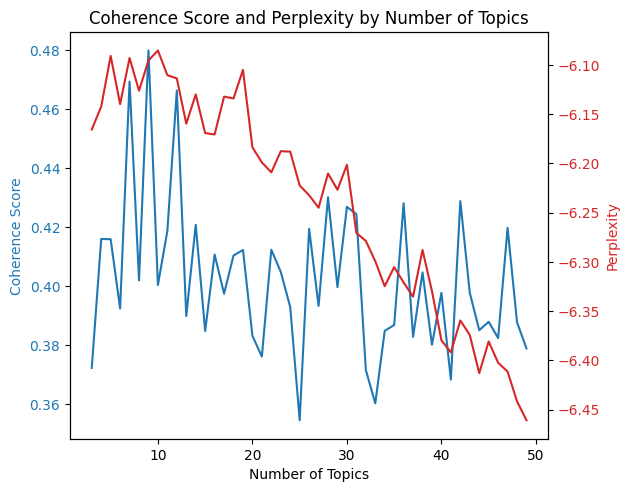

,Num_Topics,Coherence_Score,Perplexity
0,3,0.372175,-6.165729
1,4,0.415894,-6.142454
2,5,0.415815,-6.091034
3,6,0.392338,-6.139932
4,7,0.469270,-6.093158
5,8,0.401864,-6.126354
6,9,0.479798,-6.095570
7,10,0.400281,-6.085519
8,11,0.418664,-6.110606
9,12,0.466238,-6.113848


In [ ]:
results = determine_optimal_topics_with_graph(cleaned_data['cleaned_merged_column'], start=3, limit=50, step=1)
results

In [ ]:
best_topic_number = 9

## pyLDAvis with the best topics number

In [ ]:
!pip install scikit-learn
!pip install pyLDAvis



```
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import pyLDAvis.sklearn

# Load your data
# df = pd.read_csv('your_data.csv')
documents = cleaned_data['cleaned_merged_column']

# Create a CountVectorizer
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(documents)

# Number of topics
num_topics = 9

# Create LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda_model.fit(data_vectorized)

# Visualize with pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

```





```
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import pandas as pd

def prepare_and_visualize_lda_from_df(dataframe, tokenized_column, num_topics):
    """
    Prepares LDA model from a DataFrame column containing space-separated token strings
    and visualizes it using pyLDAvis.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing the data.
    tokenized_column (str): Column name with the tokenized data as space-separated strings.
    num_topics (int): Optimal number of topics to use in LDA.

    Returns:
    pyLDAvis HTML object for visualization.
    """
    # Convert space-separated strings to lists of tokens
    tokenized_data = [doc.split() for doc in dataframe[tokenized_column]]

    # Create a dictionary and corpus
    dictionary = gensim.corpora.Dictionary(tokenized_data)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]

    # Create LDA model
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

    # Prepare visualization with pyLDAvis
    vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

    return pyLDAvis.display(vis)

# Example usage
# df = pd.read_csv('your_data.csv')  # Load your dataset
# tokenized_column = 'cleaned_merged_column'  # Replace with your column name
# num_topics = 9  # Replace with your optimal number of topics
# lda_vis = prepare_and_visualize_lda_from_df(df, tokenized_column, num_topics)
# lda_vis

```



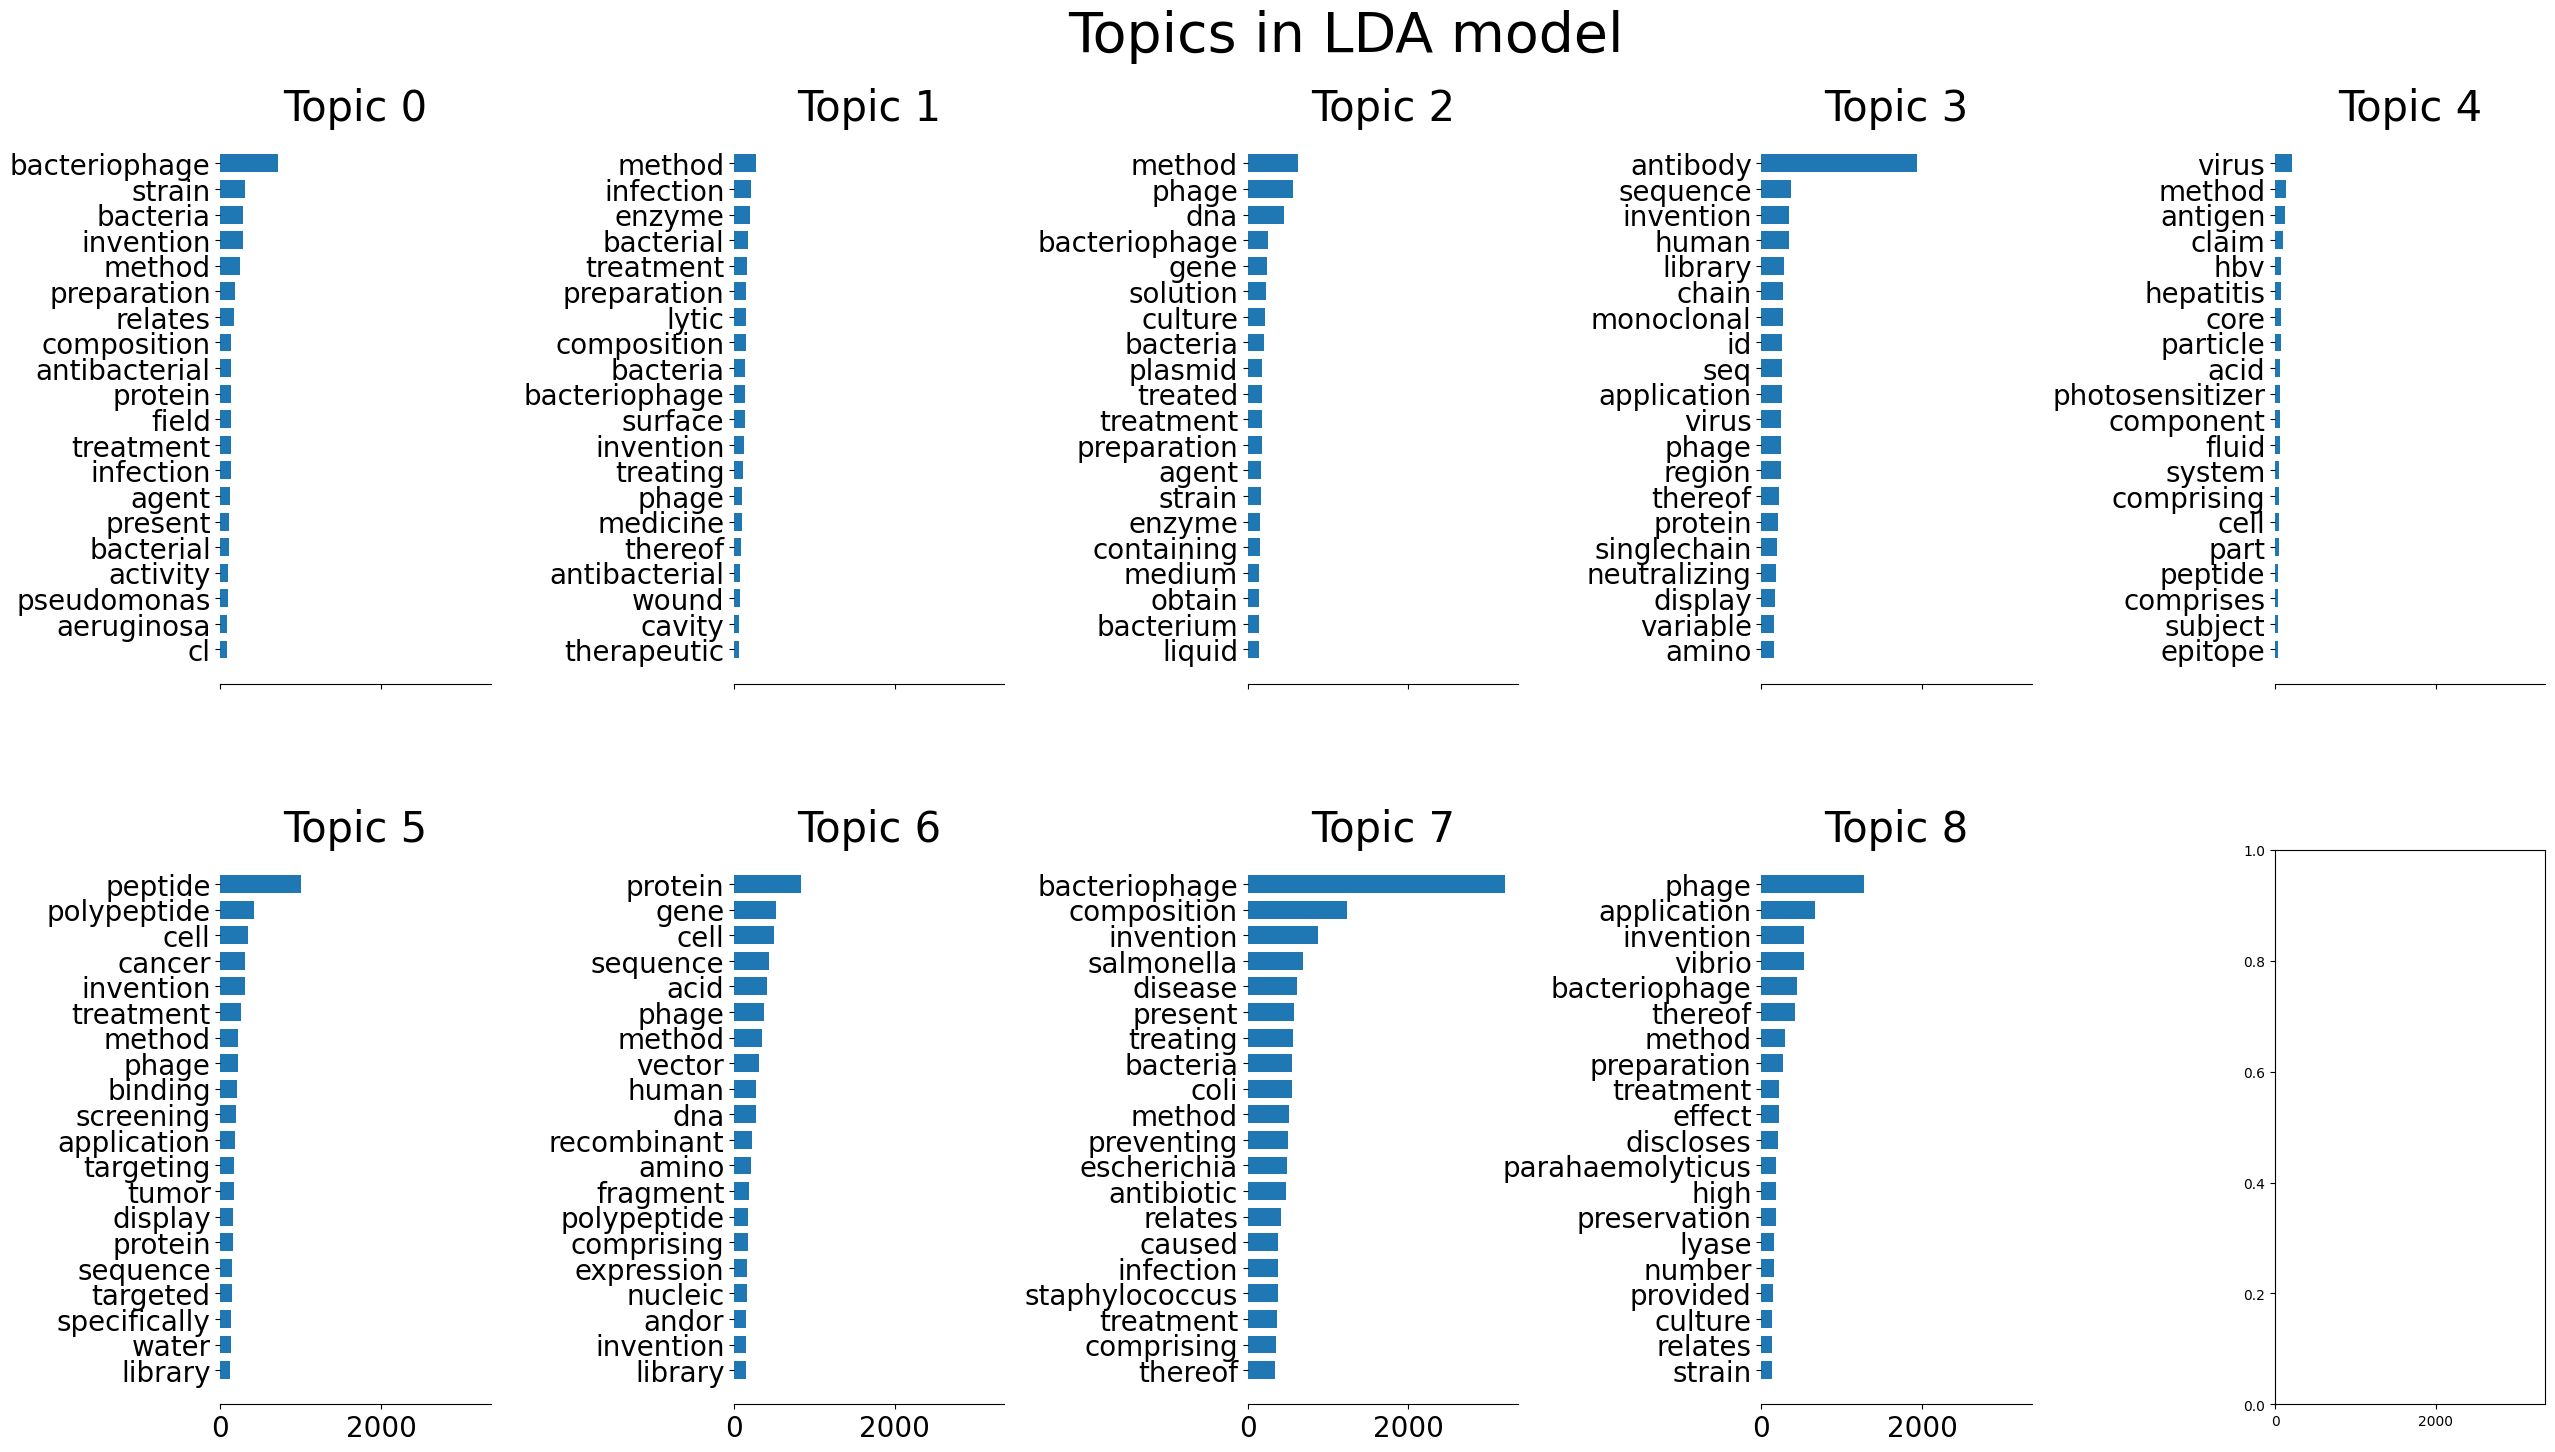

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Load your data
# df = pd.read_csv('your_data.csv')
documents = cleaned_data['cleaned_merged_column']  # Replace with your DataFrame and column

# Create a CountVectorizer
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(documents)


num_topics = int(f'{best_topic_number}')  # Replace with your optimal number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda_model.fit(data_vectorized)


import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx == num_topics:
            break
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Plot the top words
n_top_words = 20
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, feature_names, n_top_words, 'Topics in LDA model')


## Statistical Metrics

In [ ]:
def calculate_jaccard_index(lda_model):
    """
    Calculate Jaccard similarity index for each pair of topics.

    Parameters:
    lda_model (LdaModel): Trained LDA model.

    Returns:
    np.array: Jaccard similarity matrix.
    """
    num_topics = lda_model.num_topics
    jaccard_matrix = np.zeros((num_topics, num_topics))

    for i in range(num_topics):
        for j in range(num_topics):
            # Extract the top words for each topic
            topic_i_words = set(word for word, _ in lda_model.show_topic(i))
            topic_j_words = set(word for word, _ in lda_model.show_topic(j))

            # Calculate Jaccard similarity
            intersection = len(topic_i_words.intersection(topic_j_words))
            union = len(topic_i_words.union(topic_j_words))
            jaccard_similarity = intersection / union if union != 0 else 0
            jaccard_matrix[i, j] = jaccard_similarity

    return jaccard_matrix

# Example usage:
# lda_model = ...  # Your trained LDA model
# jaccard_matrix = calculate_jaccard_index(lda_model)
# plot_heatmap(jaccard_matrix, "Jaccard Similarity Between Topics")



In [ ]:
# Assuming df is your DataFrame and 'cleaned_merged_column' is the column with text data
data = cleaned_data['cleaned_merged_column'].tolist()

# Convert the data to a format suitable for LDA
tokenized_data = [doc.split() for doc in data]  # Assuming data is already tokenized

# Create a dictionary representation of the documents
dictionary = Dictionary(tokenized_data)

# Filter out extremes to remove noise and words that are too common or rare
#dictionary.filter_extremes(no_below=100, no_above=0.5)

# Convert document into the bag-of-words (BoW) format
corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=int(f'{best_topic_number}'))  # Adjust num_topics as needed
#lda_model = gensim.models.LdaModel(corpus, num_topics=f'{best_topic_number}', id2word=dictionary, passes=10) # Your trained LDA model


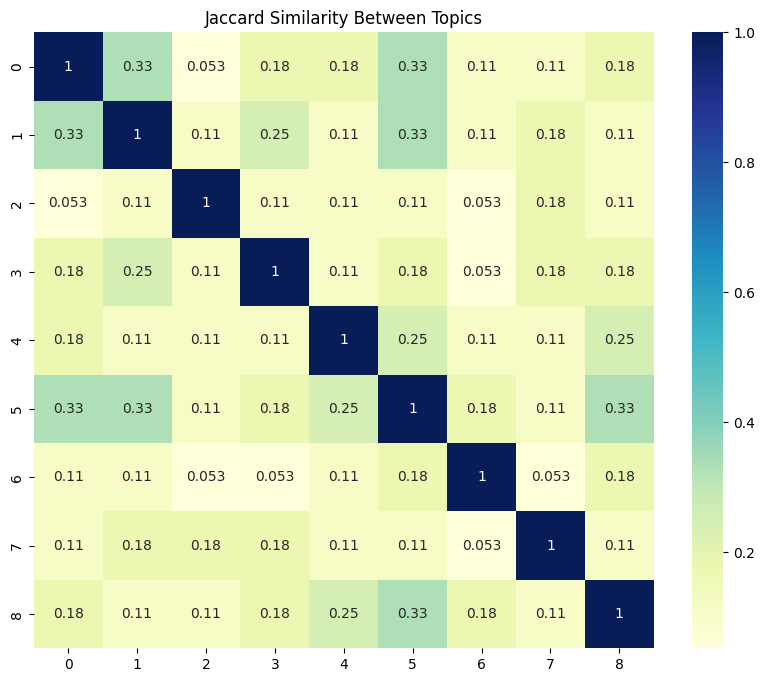

In [ ]:
jaccard_matrix = calculate_jaccard_index(lda_model)
plot_heatmap(jaccard_matrix, "Jaccard Similarity Between Topics")


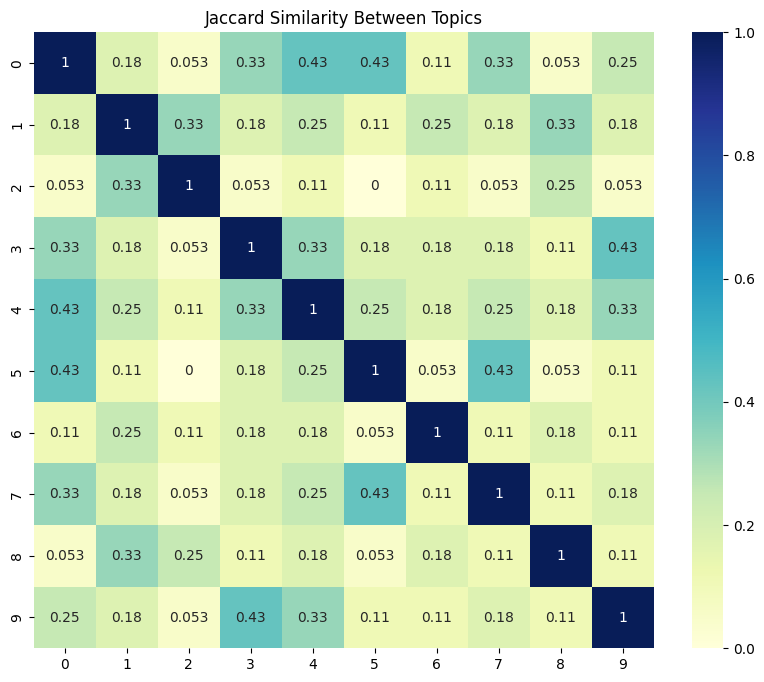

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)  # Adjust num_topics as needed


jaccard_matrix = calculate_jaccard_index(lda_model)
plot_heatmap(jaccard_matrix, "Jaccard Similarity Between Topics")


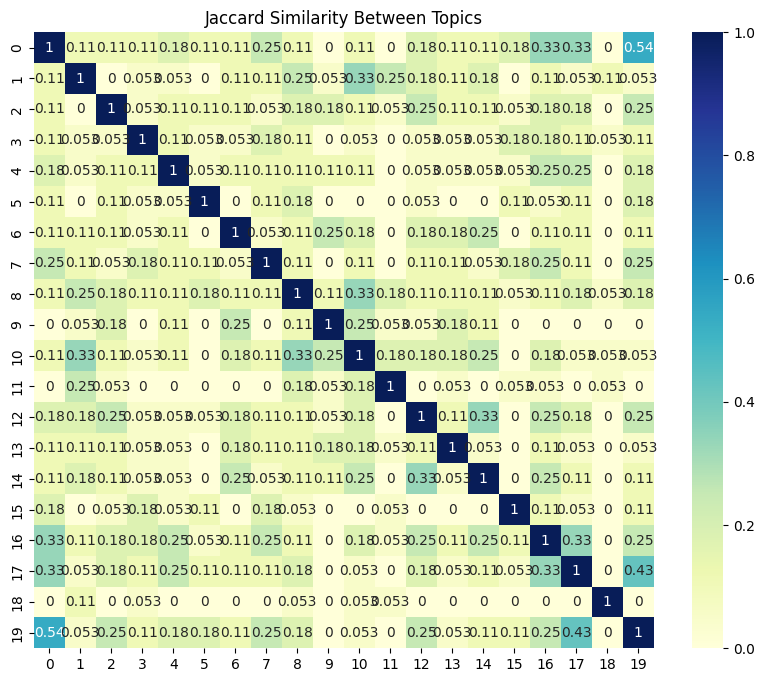

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=20)  # Adjust num_topics as needed


jaccard_matrix = calculate_jaccard_index(lda_model)
plot_heatmap(jaccard_matrix, "Jaccard Similarity Between Topics")


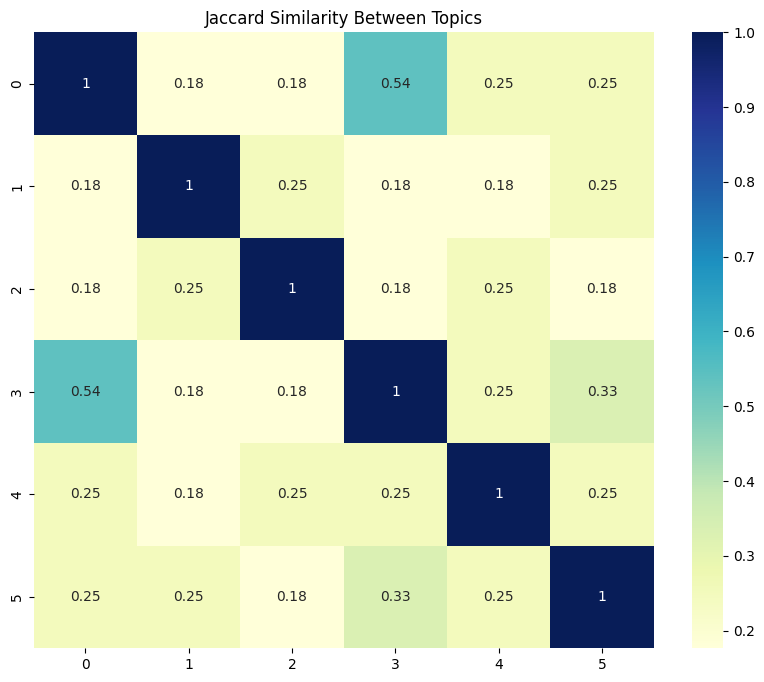

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=6)  # Adjust num_topics as needed


jaccard_matrix = calculate_jaccard_index(lda_model)
plot_heatmap(jaccard_matrix, "Jaccard Similarity Between Topics")


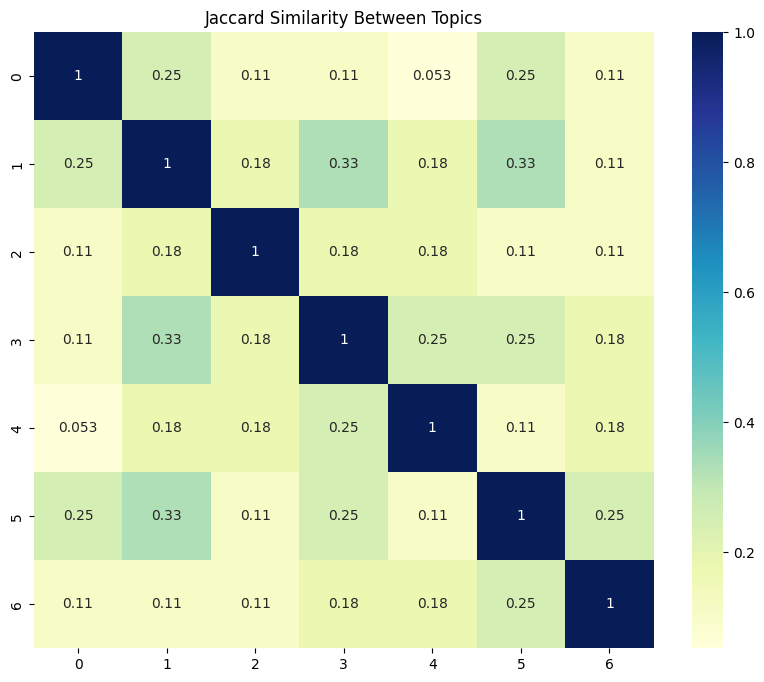

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=7)  # Adjust num_topics as needed

jaccard_matrix = calculate_jaccard_index(lda_model)
plot_heatmap(jaccard_matrix, "Jaccard Similarity Between Topics")


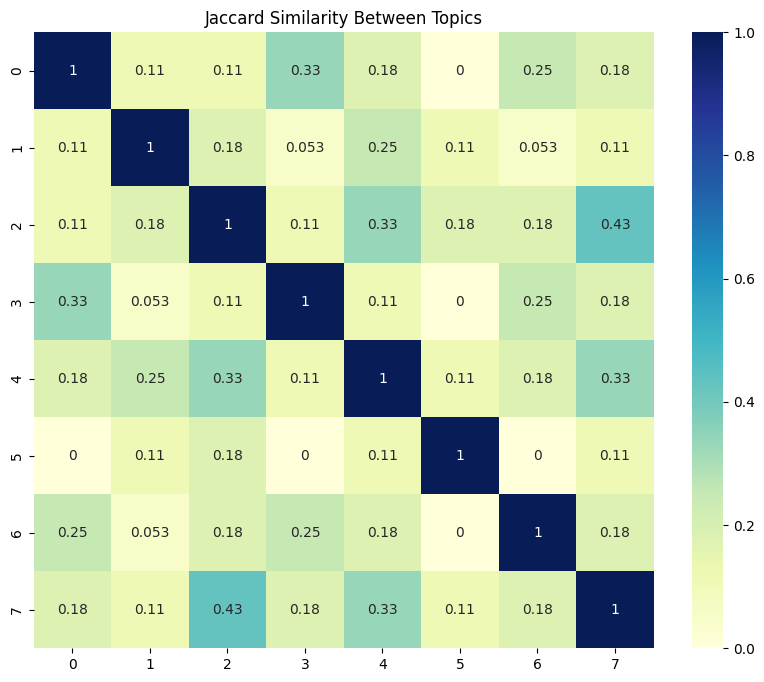

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=8)  # Adjust num_topics as needed

jaccard_matrix = calculate_jaccard_index(lda_model)
plot_heatmap(jaccard_matrix, "Jaccard Similarity Between Topics")


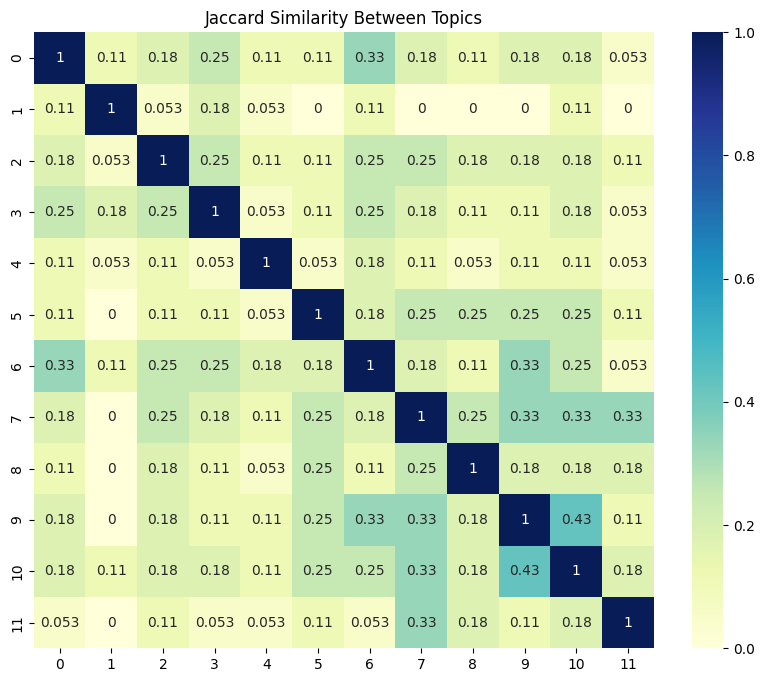

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=12)  # Adjust num_topics as needed

jaccard_matrix = calculate_jaccard_index(lda_model)
plot_heatmap(jaccard_matrix, "Jaccard Similarity Between Topics")


In [ ]:
XXXXX

NameError: ignored

In [ ]:
import numpy as np
import seaborn as sns
from gensim.matutils import jaccard
from sklearn.metrics.pairwise import cosine_similarity

def calculate_jaccard_index(lda_model, dictionary):
    """
    Calculate Jaccard similarity index for each pair of topics.

    Parameters:
    lda_model (LdaModel): Trained LDA model.
    dictionary (Dictionary): Gensim dictionary object for the corpus.

    Returns:
    np.array: Jaccard similarity matrix.
    """
    topic_terms = lda_model.get_topics()
    jaccard_matrix = np.zeros((topic_terms.shape[0], topic_terms.shape[0]))

    for i in range(topic_terms.shape[0]):
        for j in range(topic_terms.shape[0]):
            jaccard_matrix[i, j] = jaccard(topic_terms[i], topic_terms[j])

    return jaccard_matrix

def calculate_inter_topic_distance(lda_model, corpus):
    """
    Calculate inter-topic distance using cosine similarity.

    Parameters:
    lda_model (LdaModel): Trained LDA model.
    corpus (list): List of BoW representations of documents.

    Returns:
    np.array: Inter-topic distance matrix.
    """
    topic_dist = [lda_model[doc] for doc in corpus]
    topic_dist_matrix = gensim.matutils.corpus2dense(topic_dist, num_terms=lda_model.num_topics)
    distance_matrix = cosine_similarity(topic_dist_matrix.T)
    return distance_matrix

def plot_heatmap(matrix, title):
    """
    Plot heatmap of a given matrix.

    Parameters:
    matrix (np.array): Matrix to plot.
    title (str): Title of the heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap="YlGnBu")
    plt.title(title)
    plt.show()

# Usage example (to be adjusted based on your data and LDA model):
# lda_model = ...  # Your trained LDA model
# dictionary = ...  # Your Gensim dictionary
# corpus = ...  # Your corpus in BoW format

# Jaccard Index
# jaccard_matrix = calculate_jaccard_index(lda_model, dictionary)
# plot_heatmap(jaccard_matrix, "Jaccard Similarity Index Between Topics")

# Inter-Topic Distance
# inter_topic_distance_matrix = calculate_inter_topic_distance(lda_model, corpus)
# plot_heatmap(inter_topic_distance_matrix, "Inter-Topic Distance Matrix")



In [ ]:
# Assuming df is your DataFrame and 'cleaned_merged_column' is the column with text data
data = cleaned_data['cleaned_merged_column'].tolist()

# Convert the data to a format suitable for LDA
tokenized_data = [doc.split() for doc in data]  # Assuming data is already tokenized

# Create a dictionary representation of the documents
dictionary = Dictionary(tokenized_data)

# Filter out extremes to remove noise and words that are too common or rare
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Convert document into the bag-of-words (BoW) format
corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=int(f'{best_topic_number}'))  # Adjust num_topics as needed
#lda_model = gensim.models.LdaModel(corpus, num_topics=f'{best_topic_number}', id2word=dictionary, passes=10) # Your trained LDA model


In [ ]:
# Jaccard Index
jaccard_matrix = calculate_jaccard_index(lda_model, dictionary)
plot_heatmap(jaccard_matrix, "Jaccard Similarity Index Between Topics")

In [ ]:
# Inter-Topic Distance
inter_topic_distance_matrix = calculate_inter_topic_distance(lda_model, corpus)
#plot_heatmap(inter_topic_distance_matrix, "Inter-Topic Distance Matrix")


In [ ]:
plot_heatmap(inter_topic_distance_matrix, distance_matrix)

In [ ]:
def calculate_jaccard_similarity(lda_model):
    """
    Calculate Jaccard similarity index for each pair of topics.

    Parameters:
    lda_model (LdaModel): Trained LDA model.

    Returns:
    np.array: Jaccard similarity matrix.
    """
    num_topics = lda_model.num_topics
    jaccard_matrix = np.zeros((num_topics, num_topics))

    # Increase the number of top words considered for each topic
    topn_words = 50  # You can adjust this number

    for i in range(num_topics):
        for j in range(num_topics):
            topic_i_words = set([word for word, _ in lda_model.show_topic(i, topn=topn_words)])
            topic_j_words = set([word for word, _ in lda_model.show_topic(j, topn=topn_words)])
            jaccard_matrix[i, j] = jaccard(topic_i_words, topic_j_words)

    return jaccard_matrix


In [ ]:
plot_heatmap(calculate_jaccard_similarity(lda_model), jaccard_matrix)

In [ ]:
cleaned_data['cleaned_merged_column']

In [ ]:
xxxxxxxxxxxxxxx

In [ ]:
!pip install tmtoolkit

In [ ]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from statistics import mean
from sklearn.metrics import jaccard_score

In [ ]:
#XXXXXXXXXXXXXXXXXXXXXXXXX

# Topic Modeling

In [ ]:
!pip install pyLDAvis==3.4.0

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

In [ ]:
n_topics = 10

In [ ]:
lda = decomposition.LatentDirichletAllocation (n_components=n_topics, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)
# n_components is the number of topics

w1 = lda.fit_transform (tf_vectors)
h1 = lda.components_

In [ ]:
import pickle
with open(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/lda_patent_therapy_{n_topics}.pk","wb") as f1:
    pickle.dump (lda, f1)

In [ ]:
import pickle
lda = decomposition.LatentDirichletAllocation (n_components=n_topics, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)
with open(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/lda_patent_therapy_{n_topics}.pk","rb") as f1:
    lda = pickle.load (f1)

In [ ]:
#pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(lda, tf_vectors, vectorizer_tf, mds='tsne')

What did I do to make this work?

I installed pyLDAvis, but didn't import it!

I went to usr/local/lib/python3.10/dist-packages/pyLDAvis/sklearn.py
and changed get_feature_names() to get_feature_names_out()

saved it!
Then imported pyLDAvis and pyLDAvis.sklearn

In [ ]:
w1 = lda.transform (tf_vectors)

In [ ]:
w1.shape

In [ ]:
text = []
topic = []
probabilit = []
for i in range(len(idx)):
  text.append (str(data[idx[i]]))
  t = np.argmax (w1[i,:])
  topic.append (t)
  probabilit.append (w1[i,t])
probabilities = pd.DataFrame (data= {'Text':text,'Topic':topic,'Probability':probabilit})

In [ ]:
print('Topic:','Number:')
for i in range(n_topics):
  print('topic',i,'    ',list(probabilities['Topic']).count(i))

In [ ]:
# topic similarity matrix

In [ ]:
## cosine_similarity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Assuming lda_model is your trained LDA model
# Normalize the topic-word distribution
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Compute the cosine similarity matrix
topic_similarity_matrix = cosine_similarity(topic_word_distributions)

# Create a heatmap
plt.figure(figsize=(25, 15))
sns.set(font_scale=1)
sns.heatmap(
    topic_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    annot_kws={"size": n_topics},
)
plt.title("Topic Similarity Matrix")
plt.xlabel("Topic ID")
plt.ylabel("Topic ID")

# Save the figure
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_similarity_matrix_patent_therapy_23102023_{n_topics}.png', dpi=600)

plt.show()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity

# Assuming lda_model is your trained LDA model
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Compute the cosine similarity matrix
topic_similarity_matrix = cosine_similarity(topic_word_distributions)

# Perform hierarchical clustering
linkage_matrix = linkage(1 - topic_similarity_matrix, method="average")

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, color_threshold=0.5)
plt.title("Hierarchical Clustering of Topics")
plt.xlabel("Topic")
plt.ylabel("Distance")
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_clustering_dendrogram_patent_therapy_23102023_{n_topics}.png', dpi=600)

plt.show()


In [ ]:
## jaccard_similarity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation

def jaccard_similarity(vector1, vector2, threshold=0.01):
    set1 = set(np.where(vector1 > threshold)[0])
    set2 = set(np.where(vector2 > threshold)[0])
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    if union == 0:
        return 0
    else:
        return intersection / union


# Assuming lda is your trained LDA model
# Normalize the topic-word distribution
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Number of topics
n_topics = lda.components_.shape[0]

# Create Jaccard Similarity matrix
jaccard_similarity_matrix = np.zeros((n_topics, n_topics))

for i in range(n_topics):
    for j in range(n_topics):
        jaccard_similarity_matrix[i, j] = jaccard_similarity(topic_word_distributions[i, :], topic_word_distributions[j, :], threshold=0.01)


# Plot Heatmap
plt.figure(figsize=(25, 15))
sns.set(font_scale=1)
sns.heatmap(
    jaccard_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    annot_kws={"size": 12}
)
plt.title("Topic Similarity Matrix based on Jaccard Similarity")
plt.xlabel("Topic ID")
plt.ylabel("Topic ID")

# Save the figure
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_similarity_matrix_jaccard_patent_therapy_23102023_{n_topics}.png', dpi=600)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import LatentDirichletAllocation

# Define Jaccard Similarity function
def jaccard_similarity(vector1, vector2, threshold=0.01):
    set1 = set(np.where(vector1 > threshold)[0])
    set2 = set(np.where(vector2 > threshold)[0])
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    if union == 0:
        return 0
    else:
        return intersection / union


# Assuming lda is your trained LDA model
n_topics = lda.components_.shape[0]
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Create Jaccard Similarity matrix
jaccard_similarity_matrix = np.zeros((n_topics, n_topics))

for i in range(n_topics):
    for j in range(n_topics):
        jaccard_similarity_matrix[i, j] = jaccard_similarity(topic_word_distributions[i, :], topic_word_distributions[j, :], threshold=0.01)

# Perform hierarchical clustering
linkage_matrix = linkage(1 - jaccard_similarity_matrix, method="average")

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, color_threshold=0.5)
plt.title("Hierarchical Clustering of Topics based on Jaccard Similarity")
plt.xlabel("Topic ID")
plt.ylabel("Distance")
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_clustering_dendrogram_jaccard_patent_therapy_23102023_{n_topics}.png', dpi=600)

plt.show()


In [ ]:
# get_top_keywords

In [ ]:
def get_top_keywords(lda_model, vectorizer, n_words=50):
    terms = vectorizer.get_feature_names_out()
    topic_keywords = []

    for topic_idx, topic in enumerate(lda.components_):
        top_keywords_idx = topic.argsort()[::-1][:n_words]
        top_keywords = [(terms[i], topic[i]) for i in top_keywords_idx]
        topic_keywords.append(top_keywords)

    return topic_keywords

top_keywords = get_top_keywords(lda, vectorizer_tf, n_words=50)

# To display the topics with their keywords and scores
with open(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/top_keywords_patent_therapy_23102023_{n_topics}.txt", "w") as f:
    for idx, keywords in enumerate(top_keywords):
        f.write(f"Topic {idx}:\n")
        print(f"Topic {idx}:")
        for word, score in keywords:
            f.write(f"{word}, ")
            print(f"{word}", end=", ")
        f.write("\n\n")
        print("\n")

In [ ]:
# Emergent topics

In [ ]:
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

# Word Clouds for topics
def plot_wordcloud(lda, topic_id, ax, n_words=50):
    terms = vectorizer_tf.get_feature_names_out()
    word_probs = {terms[i]: prob for i, prob in enumerate(lda.components_[topic_id])}
    wc = WordCloud(background_color='white', max_words=n_words).generate_from_frequencies(word_probs)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {topic_id}", fontweight='bold')  # Bold title for each subplot

# Assuming n_topics to be the number of topics you've chosen
n_topics = n_topics  # Make sure this matches the number of topics in lda_model

# Calculate the number of rows needed
n_rows = int(np.ceil(n_topics / 5))

fig, axes = plt.subplots(n_rows, 5, figsize=(20, 4 * n_rows))

# Flatten the array and truncate it to match the number of topics
axes_flat = axes.flatten()[:n_topics]

for ax, topic_id in zip(axes_flat, range(n_topics)):
    plot_wordcloud(lda, topic_id, ax)

# Remove extra subplots
for idx in range(n_topics, len(axes.flatten())):
    fig.delaxes(axes.flatten()[idx])

plt.suptitle("Word Clouds for LDA Topics", fontweight='bold')  # Bold main title
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/wordclouds_patent_therapy_23102023_{n_topics}.png', dpi=600)  # Use raw string for path
plt.show()


In [ ]:
# Attach Discovered Topic Labels to Original scholar publications

In [ ]:
final_topics = lda.transform(tf_vectors)
final_topics.shape

In [ ]:
df_filtered["Topic N°"] = final_topics.argmax(axis=1)
df_filtered.head()

In [ ]:
# Save data to CSV and Pickle formats
df_filtered.to_csv(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_probability_patent_therapy_23102023_{n_topics}.csv', index=False)
df_filtered.to_pickle(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_probability_patent_therapy_23102023_{n_topics}.pkl')

df_filtered.head()

In [ ]:
df_filtered['Topic N°'].value_counts()

In [ ]:
# Frequency Counting

In [ ]:
# Step 1: Group data by 'Publication Year' and 'topic', then count occurrences
topic_counts_by_year = df_filtered.reset_index().groupby(['Publication Year', 'Topic N°']).size().unstack(fill_value=0)

# Step 2: Calculate the total count of each topic
total_counts = topic_counts_by_year.sum()

# Step 3: Sort columns by total count
sorted_columns = total_counts.sort_values(ascending=False).index
topic_counts_by_year = topic_counts_by_year[sorted_columns]

# Step 4: Add a row with the total count of each topic
topic_counts_by_year.loc['Total'] = total_counts.loc[sorted_columns]

# Save the DataFrame to CSV and pickle files
topic_counts_by_year.to_csv(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_counts_by_year_patent_therapy_23102023_{n_topics}.csv')
topic_counts_by_year.to_pickle(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_counts_by_year_patent_therapy_23102023_{n_topics}.pkl')

# This will give you a DataFrame where each row is a year (plus a 'Total' row at the bottom),
# and each column is the count of documents associated with a topic for that year (and the total count).

# Display the updated DataFrame
topic_counts_by_year

In [ ]:
topic_counts_by_year.shape

In [ ]:
# Evolution Curve for Each Topic

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the DataFrame from the CSV file (assuming it's stored as 'topic_counts_by_year.csv')
# Replace this line with your actual data if it's not in a CSV
#topic_counts_by_year = pd.read_csv('topic_counts_by_year.csv', index_col='Publication Year')

# Remove the 'Total' row if it exists
if 'Total' in topic_counts_by_year.index:
    topic_counts_by_year = topic_counts_by_year.drop(index=['Total'])

# Sort columns by topic name
topic_counts_by_year = topic_counts_by_year.sort_index(axis=1)

# Define the number of topics (make sure this matches your data)
n_topics = len(topic_counts_by_year.columns)

# Calculate the number of rows needed for subplots
n_rows = (n_topics + 4) // 5  # +4 for rounding up

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, 5, figsize=(20, n_rows * 3.5))

# Flatten the array to easily iterate over it
axes_flat = axes.flatten()

# Loop through each topic and plot its curve on a separate subplot
for i, topic in enumerate(topic_counts_by_year.columns):
    axes_flat[i].plot(
        topic_counts_by_year.index,
        topic_counts_by_year[topic]
    )
    axes_flat[i].set_title(f'Topic {topic}')
    axes_flat[i].set_xlabel('Year')
    axes_flat[i].set_ylabel('Frequency')
    axes_flat[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove extra subplots
for i in range(n_topics, len(axes_flat)):
    fig.delaxes(axes_flat[i])

# Add a main title for the entire figure
fig.suptitle('Evolution Curve for Each Topic', fontsize=16, fontweight='bold')

# Save the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the main title
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_evolution_curves_subplot_ordered_patent_therapy_23102023_{n_topics}.png', dpi=600)

# Show the figure
plt.show()


In [ ]:
# Temporal Heatmaps: Display how topic proportions change over time.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assume you already have topic_counts_by_year DataFrame

# Remove the 'Total' row if it exists
if 'Total' in topic_counts_by_year.index:
    topic_counts_by_year = topic_counts_by_year.drop(index=['Total'])

# Sort columns by topic name
topic_counts_by_year = topic_counts_by_year.sort_index(axis=1)

# Calculate the total count for each year (row-wise sum)
total_counts_by_year = topic_counts_by_year.sum(axis=1)

# Normalize frequencies to get proportions
proportions_by_year = topic_counts_by_year.divide(total_counts_by_year, axis=0)

# Create the heatmap
plt.figure(figsize=(25, 10))
sns.heatmap(proportions_by_year.fillna(0), annot=True, cmap="coolwarm", cbar=True, xticklabels=True, yticklabels=True)

# Add labels and title
plt.title('Temporal Heatmap of Topic Proportions')
plt.xlabel('Topics')
plt.ylabel('Publication Year')

# Save the figure
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/temporal_heatmap_topic_proportions_patent_therapy_23102023_{n_topics}.png")  # Save the plot to a PNG file

# Show the plot
plt.show()
